# Experiment II



## Introduction

This notebook contains the code to execute the second experiment of this project. The basic set up consists on three elements:

- An **environment**: A mass $M$ and a infinite horizontal surface with friction coefficient $\mu$ respect to the mass $M$. This environment automatically shoots a bullet of mass $m$ with a velocity $v$ when an episode is started. The mass $M$ is the only parameter restarted each episode by sampling uniformly at random from the interval $[M_\text{min}, M_\text{max}]$. For more information and details, go to the [class documentation](TODO) of this environment. 
- An **agent** that consists of two sub-agents:
    - **Experimenter** or **policy maker:** its objective is to decide which actions to take to gather the data. After the automatic shooting we give the agent the choice between two sensors and two tries per episode.
        - A low precision but wide range (LPWR) position  sensor. It works as follow: the landing zone is divided into four regions or zones of equal size. Each time the box is shot it lands in one of the zones and this sensor if activated gives the middle point of the zone. For example, in the image below this sensor would produce the outcome: $3$, since it's the middle point of the zone $B$. This allows to know roughly where the box landed, but with low accuracy.
        - A high precision but narrow range (HPNR) position sensor. It works as follow: to activate it you need to specify a region and if the box landed on the specified region the outcome of the sensor is the exact position of the box, otherwise it outputs a constant negative value (set to $-1$) representing a failed measurement. For example, in the image below if this sensor is placed in the zone $B$ it will output the value of $x$ and if placed in any of the other zones it outputs $-1.
        
    - **Analyzer** or **encoder:** the goal of this agent is to process the data collected by the Experimenter and to use it to make predictions about physical properties of the system. In this case the Analyzer takes the actions and the outcomes of the experimenter to make a prediction about the position of the mass *M* after a test shooting. In this test shooting the velocity of the bullet, known to the analyzer, is sampled uniformly at random from a limited range. 
    
- **Orchestration**: we call orchestration everything that connects the environments and the agents to build the training loop. The code in this notebook is the orchestration. 

Note that this set up is slightly different from an usual Reinforcement Learning set up, because the rewards do not come from the environment but from the performance of the agent to predict aspects of the environment. Another perspective to this set up would be to include the Analyzer as another element of the environment. However, assuming that perspective means that we have a environment that changes the reward system dynamically, which can be quite a challenging Reinforcement Learning problem. 

The goal of the Analyzer is to understand the data provided by the measurements of the Experimenter and unveil the correlation between those measurements and the distance traveled by the mass $M$ in the test shooting. The goal of the Experimenter is to learn the optimal strategy to use the sensors to provide the best possible data to the Analyzer. In this case the strategy is obvious: first to take the LPWR sensor to find in which zone the mass landed, and then to use that information to place the HPNR sensor in that zone. The main difficulty here is that the Experimenter needs to memorize the outcome of the first measurement and use it to choose the second measurement. It requires a dynamical strategy for the experiment instead of a predefined one from the beginning.  


![alt text](Experiment2.svg)

## Orchestration

In this section we are going to implement the training. The code is explained with in-line comments.

2000000/2000000 episodes(100.0%)
Elapsed time: 265 min 1s
Est. completion time: 265 min 1s,
        Est. remaining time: 0 min 0s
Training completed!


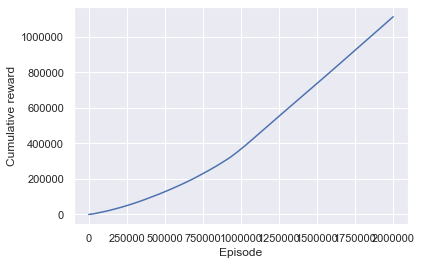

,Zone,Exact position,Action 1,Outcome 1,Action 2,Outcome 2,Reward,d_predicted,d_test,Exploration rate
0,D,7.958,1,-1.000,4,7.958,0.000,0.000,3.361,1.0
1,A,0.918,2,-1.000,4,-1.000,0.000,-0.674,1.791,1.0
2,A,0.840,2,-1.000,2,-1.000,0.000,-0.661,1.881,1.0
3,A,1.958,2,-1.000,4,-1.000,0.000,-0.563,3.390,1.0
4,A,1.145,4,-1.000,4,-1.000,0.000,-1.009,0.929,1.0
...,...,...,...,...,...,...,...,...,...,...
1999995,A,1.470,1,1.470,1,1.470,0.593,0.475,0.452,-0.0
1999996,B,2.549,1,-1.000,2,2.549,0.999,0.640,0.639,-0.0
1999997,B,3.268,1,-1.000,2,3.268,1.000,2.762,2.762,-0.0
1999998,A,0.807,1,0.807,1,0.807,0.729,0.915,0.880,-0.0


In [15]:
# IMPORTS ===================================================================

import random
import numpy as np
import matplotlib.pyplot as plt
import time
import pandas as pd
from IPython.display import clear_output
from keras.utils import to_categorical
import seaborn as sns
sns.set()
# We import the agents and the environment from the 
# modules created in advance.
from Modules.rlagents import Q_Learning, DQN
from Modules.analyzers import Two_Layers_single_output
from Modules.environments import Two_Sensors

# CONSTANTS, INSTANTIATIONS, INITIALIZATION ===============================

N_Episodes = 2000000 # Number of episodes to train 
count = 0 # Initialization of a counter

# We instantiate the classes of each element
env = Two_Sensors() 
experimenter1 = Q_Learning(iterations=N_Episodes, output_size=5)
experimenter2 = DQN(iterations=N_Episodes, input_size=6, output_size=5)
analyzer = Two_Layers_single_output(input_size=5)

# Save time for verbose purposes
t0 = time.time()
t1 = time.time()

# First random initialization of the variables. This part is needed since 
# some recurrent parts of the loop need from some data to start with.

action1 = experimenter1.get_next_action()
outcome1 = env.take_action(action1)
action2 = random.randint(0,4)
outcome2 = env.position_exact
d_test = random.uniform(0.8,8)
y_predicted = [0]
reward = 0

# Auxiliar variables for collecting data
values = []
df=pd.DataFrame(columns = ['Zone', 'Exact position', 'Action 1', 
                           'Outcome 1', 'Action 2', 'Outcome 2', 'Reward', 
                           'd_predicted', 'd_test', 'Exploration rate'])
total_reward_list = []

# MAIN LOOP =================================================================

while count < N_Episodes:
    
    # Record the data from the previous episode.
    if env.position_zone==1:
        zone='A'
    elif env.position_zone==3:
        zone='B'
    elif env.position_zone==5:
        zone='C'
    elif env.position_zone==7:
        zone='D'
    values.append([zone, env.position_exact, 
                   action1, outcome1, action2, outcome2, float(reward), 
                   y_predicted[0], d_test, experimenter2.exploration_rate ])
    total_reward_list.append(env.total_reward)
   
    # First part of the loop ...-...........................................
    
    # Store the ending state of the previous episode
    old_state =  np.append(to_categorical(action1, 5), [outcome1])
    # Restart the mass of the environment
    env.restart_mass()
    # Get the new action of experimenter 1 and its resulting outcome
    action1 = experimenter1.get_next_action()
    outcome1 = env.take_action(action1)
    # Store the new state in a variable
    current_state = np.append(to_categorical(action1, 5), [outcome1])
    # We use the old_state and the current_state to train the experimenter 2.
    # We can understand this as the experimenter2 being a traditional RL 
    # agent interacting with an environment whose states consists on the
    # action and outcome of the experimenter 1.
    experimenter2.online_train(old_state, action2, reward, current_state)
    # Let the experimenter 2 take a new action and store its outcome
    action2 = experimenter2.get_next_action(state=current_state)
    outcome2 = env.take_action(action2)
    # Do a test shooting to train the analyzer
    v_train, d_train = env.test_shooting()
    measurements = env.get_measurements(action1, outcome1, action2, outcome2,
                                         v_train)
    X_train, y_train = env.reshape_for_analyzer(measurements, d_train) 
    analyzer.train(X_train, y_train)
    
    # Do another test shooting to test the performance of the analyer and
    # generate the reward.
    v_test, d_test = env.test_shooting()
    measurements = env.get_measurements(action1,outcome1, action2, outcome2,
                                         v_test)
    X_test, y_test = env.reshape_for_analyzer(measurements, d_test)
    
    # Predict value for the position of the mass "d" and generate reward.
    y_predicted = analyzer.predict(X_test)[0]
    reward = env.give_reward(y_predicted, d_test)
    
    # Use the reward to train the first experimenter.
    experimenter1.update(action1, reward)

# Display training status....................................................
    count = count + 1
    refresh_rate = 5000
    if count % (N_Episodes/refresh_rate) == 0:
        clear_output()
        t2 = time.time()
        m, s = divmod(t2-t1, 60)
        mt, st = divmod(t2-t0, 60)
        me, se = divmod(((t2-t0)/count)*N_Episodes, 60)
        mr, sr = divmod(((t2-t0)/count)*N_Episodes-t2+t0, 60)
        print (str(int(count)) + '/' +  str(N_Episodes) + " episodes" + 
               '(' + str(100*count/N_Episodes)+ '%)')
        print('Elapsed time: {} min {}s'.format(int(mt), int(st)))
        print("""Est. completion time: {} min {}s,
        Est. remaining time: {} min {}s""".format(int(me), int(se), int(mr),
                                                  int(sr)))
        t1 = time.time()
print('Training completed!')


plt.plot(range(len(total_reward_list)), total_reward_list)
plt.ylabel("Cumulative reward")
plt.xlabel("Episode")
plt.show()


df=pd.DataFrame(values, columns = ['Zone', 'Exact position', 'Action 1', 
                                   'Outcome 1', 'Action 2', 'Outcome 2', 
                                   'Reward', 'd_predicted', 'd_test', 
                                   'Exploration rate'])
df.to_csv('df_nuevo.csv')
df.round(3)

## Visualization of the training and discussion

In this section we are going to plot and discuss several data of the training process. First we are going to see how the model works. To do it let's trim our dataset to include only a sample from the very last part of the training.

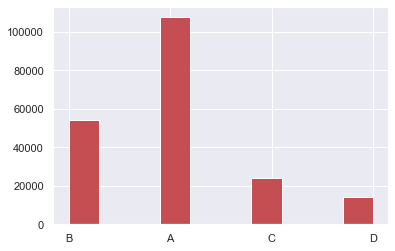

In [16]:
zones = ['A', 'B', 'C', 'D']
sample_size = 0.1
sample=df.loc[np.r_[N_Episodes-N_Episodes*sample_size:N_Episodes], :]
# We plot an histogram of the zone distribution to observe the expected
# unbalanced distribution of landing zones
for zone in zones:
    sample['Zone'].hist()

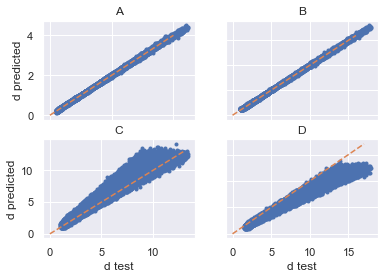

In [17]:
figs, axs = plt.subplots(2,2)
j=0
k=0
for zone in zones:
    df_aux = sample[sample['Zone']==zone]
    aux = range(0, int(np.ceil(max(df_aux['d_test']))))
    axs[k,j].plot(df_aux['d_test'], df_aux['d_predicted'],'.',label="Predictions")
    axs[k,j].plot(aux, aux,'--',label = 'y=x')
    axs[k,j].set_title(zone)
    axs[j,k].set(xlabel='d test', ylabel='d predicted')
    axs[j,k].label_outer()
    j=(j+1)%2
    if j==0:
        k=(k+1)%2

for ax in axs.flat:
    ax.label_outer()
plt.savefig('generated_figures/AllZones.svg')


In [18]:
def plot_pred_vs_test(sample,zone):
    df_aux = sample[sample['Zone']==zone]
    plt.plot(df_aux['d_test'], df_aux['d_predicted'],'.',label="Predictions")
    aux = range(0, int(np.ceil(max(df_aux['d_test']))))
    plt.plot(aux, aux,'--',label = 'y=x')
    plt.xlabel('d test')
    plt.ylabel('d predicted')
    plt.legend()
    display(df_aux.round(3))

,Zone,Exact position,Action 1,Outcome 1,Action 2,Outcome 2,Reward,d_predicted,d_test,Exploration rate
1800003.0,A,1.238,1,1.238,1,1.238,0.973,0.877,0.867,-0.0
1800004.0,A,1.289,1,1.289,1,1.289,0.974,1.394,1.410,-0.0
1800006.0,A,1.461,1,1.461,1,1.461,0.975,0.373,0.368,-0.0
1800007.0,A,1.795,1,1.795,1,1.795,0.976,1.826,1.806,-0.0
1800011.0,A,1.438,1,1.438,1,1.438,0.932,1.044,1.025,-0.0
...,...,...,...,...,...,...,...,...,...,...
1999992.0,A,1.287,1,1.287,1,1.287,0.973,2.375,2.347,-0.0
1999994.0,A,0.950,1,0.950,1,0.950,0.824,0.331,0.342,-0.0
1999995.0,A,1.470,1,1.470,1,1.470,0.593,0.475,0.452,-0.0
1999998.0,A,0.807,1,0.807,1,0.807,0.729,0.915,0.880,-0.0


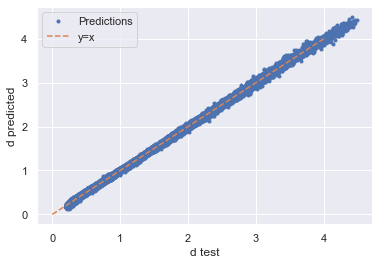

In [19]:
plot_pred_vs_test(sample,'A')
plt.savefig('generated_figures/zoneA.svg')

,Zone,Exact position,Action 1,Outcome 1,Action 2,Outcome 2,Reward,d_predicted,d_test,Exploration rate
1800000.0,B,2.474,1,-1.0,2,2.474,0.334,1.304,1.408,-0.0
1800001.0,B,3.421,1,-1.0,2,3.421,0.815,3.207,3.313,-0.0
1800002.0,B,2.068,1,-1.0,2,2.068,0.910,2.973,3.039,-0.0
1800010.0,B,2.161,1,-1.0,2,2.161,0.731,0.671,0.699,-0.0
1800016.0,B,3.182,1,-1.0,2,3.182,0.973,5.624,5.690,-0.0
...,...,...,...,...,...,...,...,...,...,...
1999985.0,B,2.714,1,-1.0,2,2.714,0.978,1.939,1.918,-0.0
1999990.0,B,2.310,1,-1.0,2,2.310,0.980,3.892,3.853,-0.0
1999993.0,B,2.361,1,-1.0,2,2.361,0.967,2.209,2.181,-0.0
1999996.0,B,2.549,1,-1.0,2,2.549,0.999,0.640,0.639,-0.0


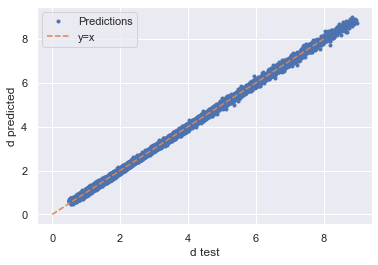

In [20]:
plot_pred_vs_test(sample,'B')
plt.savefig('.\generated_figures\zoneB.svg')

,Zone,Exact position,Action 1,Outcome 1,Action 2,Outcome 2,Reward,d_predicted,d_test,Exploration rate
1800005.0,C,4.203,1,-1.0,2,-1.0,0.000,9.785,7.607,-0.0
1800009.0,C,5.315,1,-1.0,2,-1.0,0.430,2.420,2.273,-0.0
1800018.0,C,5.632,1,-1.0,2,-1.0,0.415,6.986,7.482,-0.0
1800029.0,C,4.415,1,-1.0,2,-1.0,0.000,9.830,8.118,-0.0
1800056.0,C,4.643,1,-1.0,2,-1.0,0.000,2.931,2.181,-0.0
...,...,...,...,...,...,...,...,...,...,...
1999954.0,C,4.402,1,-1.0,2,-1.0,0.000,2.827,2.232,-0.0
1999955.0,C,4.864,1,-1.0,2,-1.0,0.007,4.747,4.099,-0.0
1999958.0,C,4.738,1,-1.0,2,-1.0,0.011,10.703,9.303,-0.0
1999964.0,C,4.408,1,-1.0,2,-1.0,0.000,11.687,9.636,-0.0


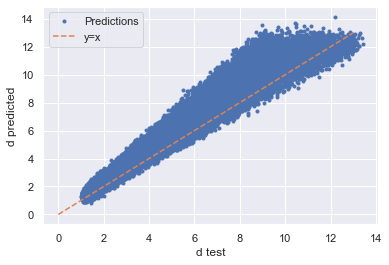

In [21]:
plot_pred_vs_test(sample,'C')
plt.savefig('generated_figures/zoneC.svg')

,Zone,Exact position,Action 1,Outcome 1,Action 2,Outcome 2,Reward,d_predicted,d_test,Exploration rate
1800008.0,D,6.426,1,-1.0,2,-1.0,0.002,4.001,4.874,-0.0
1800024.0,D,7.298,1,-1.0,2,-1.0,0.000,1.623,2.214,-0.0
1800027.0,D,7.299,1,-1.0,2,-1.0,0.000,6.070,8.451,-0.0
1800030.0,D,7.936,1,-1.0,2,-1.0,0.000,3.856,5.644,-0.0
1800093.0,D,6.129,1,-1.0,2,-1.0,0.228,3.073,3.362,-0.0
...,...,...,...,...,...,...,...,...,...,...
1999948.0,D,7.878,1,-1.0,2,-1.0,0.000,3.644,5.110,-0.0
1999966.0,D,6.499,1,-1.0,2,-1.0,0.012,4.672,5.488,-0.0
1999967.0,D,6.680,1,-1.0,2,-1.0,0.001,10.134,12.492,-0.0
1999969.0,D,6.903,1,-1.0,2,-1.0,0.000,3.784,4.703,-0.0


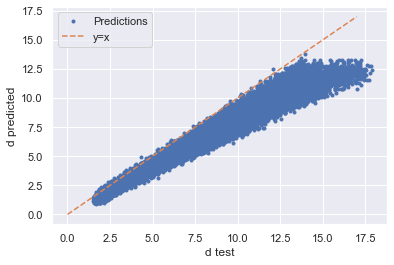

In [22]:
plot_pred_vs_test(sample,'D')
plt.savefig('generated_figures/zoneD.svg')

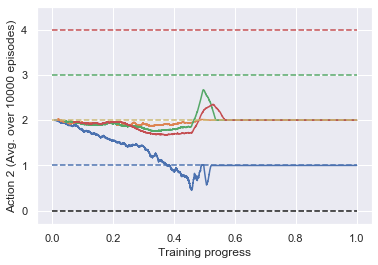

In [23]:
rolling_window = int(N_Episodes/200)
for zone in zones:
    df_aux=df[df['Zone'] == zone]
    average_reward = df_aux['Action 2'].rolling(rolling_window).mean()
    plt.plot(np.array(range(len(average_reward)))/len(average_reward), 
             average_reward, label = 'Box landed in Zone ' + zone)
plt.ylim([-0.3,4.5])
plt.xlabel('Training progress')
plt.ylabel('Action 2 (Avg. over ' + str(rolling_window) + ' episodes)')
aux = [0,1]
ones = np.ones(2)
plt.plot(aux, ones,'b--')
plt.plot(aux, 2*ones,'y--')
plt.plot(aux, 3*ones,'g--')
plt.plot(aux, 4*ones,'r--')
plt.plot(aux, np.zeros(2),'k--')
# plt.legend(loc='upper left')
plt.savefig('generated_figures/action2.svg')

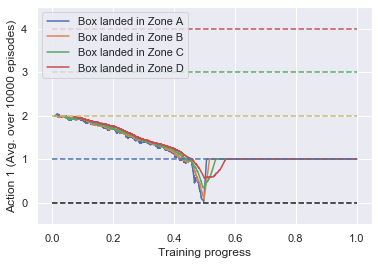

In [24]:
for zone in zones:
    df_aux=df[df['Zone'] == zone]
    average_reward = df_aux['Action 1'].rolling(rolling_window).mean()
    plt.plot(np.array(range(len(average_reward)))/len(average_reward), 
             average_reward, label = 'Box landed in Zone ' + zone)
plt.ylim([-0.5,4.5])
plt.xlabel('Training progress')
plt.ylabel('Action 1 (Avg. over ' + str(rolling_window) + ' episodes)')
aux = [0,1]
ones = np.ones(2)
plt.plot(aux, ones,'b--')
plt.plot(aux, 2*ones,'y--')
plt.plot(aux, 3*ones,'g--')
plt.plot(aux, 4*ones,'r--')
plt.plot(aux, np.zeros(2),'k--')
plt.legend(loc='upper left')
plt.savefig('generated_figures/action1.svg')

C:\Users\eduar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:14: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  
C:\Users\eduar\AppData\Roaming\Python\Python37\site-packages\IPython\core\pylabtools.py:132: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


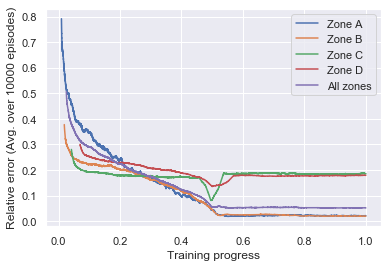

In [25]:
for zone in zones:
    df_aux=df[df['Zone'] == zone]
    rel_error = abs((df_aux['d_test']-df_aux['d_predicted'])/df_aux['d_test'])
    avg_rel_error = rel_error.rolling(rolling_window).mean()
    plt.plot(np.array(range(len(avg_rel_error)))/len(avg_rel_error),
             avg_rel_error, label ='Zone '+ zone)
rel_error = abs((df['d_test']-df['d_predicted'])/df['d_test'])
avg_rel_error = rel_error.rolling(5*rolling_window).mean()
plt.plot(np.array(range(len(avg_rel_error)))/len(avg_rel_error), 
         avg_rel_error,  label = 'All zones')
plt.xlabel('Training progress')
plt.ylabel('Relative error (Avg. over ' + str(rolling_window) + ' episodes)')
plt.legend()
plt.savefig('generated_figures/Relative-Error.svg')

C:\Users\eduar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':


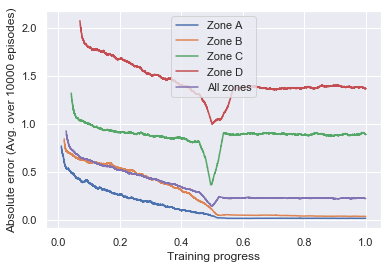

In [26]:
for zone in zones:
    df_aux=df[df['Zone'] == zone ]
    rel_error = abs(df_aux['d_test']-df_aux['d_predicted'])
    avg_rel_error = rel_error.rolling(rolling_window).mean()
    plt.plot(np.array(range(len(avg_rel_error)))/len(avg_rel_error), avg_rel_error, label ='Zone '+ zone)
rel_error = abs(df['d_test']-df['d_predicted'])
avg_rel_error = rel_error.rolling(5*rolling_window).mean()
plt.plot(np.array(range(len(avg_rel_error)))/len(avg_rel_error), avg_rel_error,  label = 'All zones')
plt.xlabel('Training progress')
plt.ylabel('Absolute error (Avg. over ' + str(rolling_window) + ' episodes)')
plt.legend()
plt.savefig('generated_figures/Absolute-Error.svg')

C:\Users\eduar\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:12: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  if sys.path[0] == '':


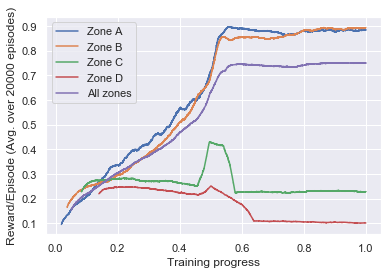

In [27]:
for zone in zones:
    dfa=df[df['Zone'] == zone ]
    reward = dfa['Reward']
    avg_reward = reward.rolling(2*rolling_window).mean()
    plt.plot(np.array(range(len(avg_reward)))/len(avg_reward), avg_reward, label ='Zone '+ zone)
reward = df['Reward']
avg_reward = reward.rolling(10*rolling_window).mean()
plt.plot(np.array(range(len(avg_reward)))/len(avg_reward), avg_reward, label = 'All zones')
plt.xlabel('Training progress')
plt.ylabel('Reward/Episode (Avg. over ' + str(2*rolling_window) + ' episodes)')
plt.legend()
plt.savefig('generated_figures/rewards.svg')